# MTurk Similarity Comparison User Study 2: Results

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [4]:
df = pd.read_csv('~/Downloads/Batch_3582472_batch_results.csv')

In [5]:
print('Average worker time was {:.2f} minutes'.format(np.mean(df['WorkTimeInSeconds']) / 60))

Average worker time was 5.83 minutes


In [100]:
pattern_sizes = 3
pattern_sizes_names = ['3 kb', '12 kb', '120 kb']
pattern_sizes_shortnames = ['3kb', '12kb', '120kb']
comparisons = 9
techniques = 2
technique_options = ['A', 'B']
technique_names = ['CAE*', 'ED']
knn = 5

## Aggregate results

In [7]:
results_3kb = []
results_12kb = []
results_120kb = []

results = [results_3kb, results_12kb, results_120kb]

rows_3kb = np.where(df['Input.T00A'].str.contains('3KB', regex=False).values)[0]
rows_12kb = np.where(df['Input.T00A'].str.contains('12KB', regex=False).values)[0]
rows_120kb = np.where(df['Input.T00A'].str.contains('120KB', regex=False).values)[0]

for c in np.arange(comparisons):
    c_res_3kb = []
    c_res_12kb = []
    c_res_120kb = []
    for t in technique_options:
        t_res_3kb = []
        t_res_12kb = []
        t_res_120kb = []
        for k in np.arange(knn):
            try:
                t_res_3kb.append(df['Answer.T{}{}{}.{}'.format(c, k, t, t)][rows_3kb].value_counts().loc[True])
            except KeyError:
                t_res_3kb.append(0)
            try:
                t_res_12kb.append(df['Answer.T{}{}{}.{}'.format(c, k, t, t)][rows_12kb].value_counts().loc[True])
            except KeyError:
                t_res_12kb.append(0)
            try:
                t_res_120kb.append(df['Answer.T{}{}{}.{}'.format(c, k, t, t)][rows_120kb].value_counts().loc[True])
            except KeyError:
                t_res_120kb.append(0)
        c_res_3kb.append(t_res_3kb)
        c_res_12kb.append(t_res_12kb)
        c_res_120kb.append(t_res_120kb)
    results_3kb.append(c_res_3kb)
    results_12kb.append(c_res_12kb)
    results_120kb.append(c_res_120kb)
    
results = np.array(results)

## Results

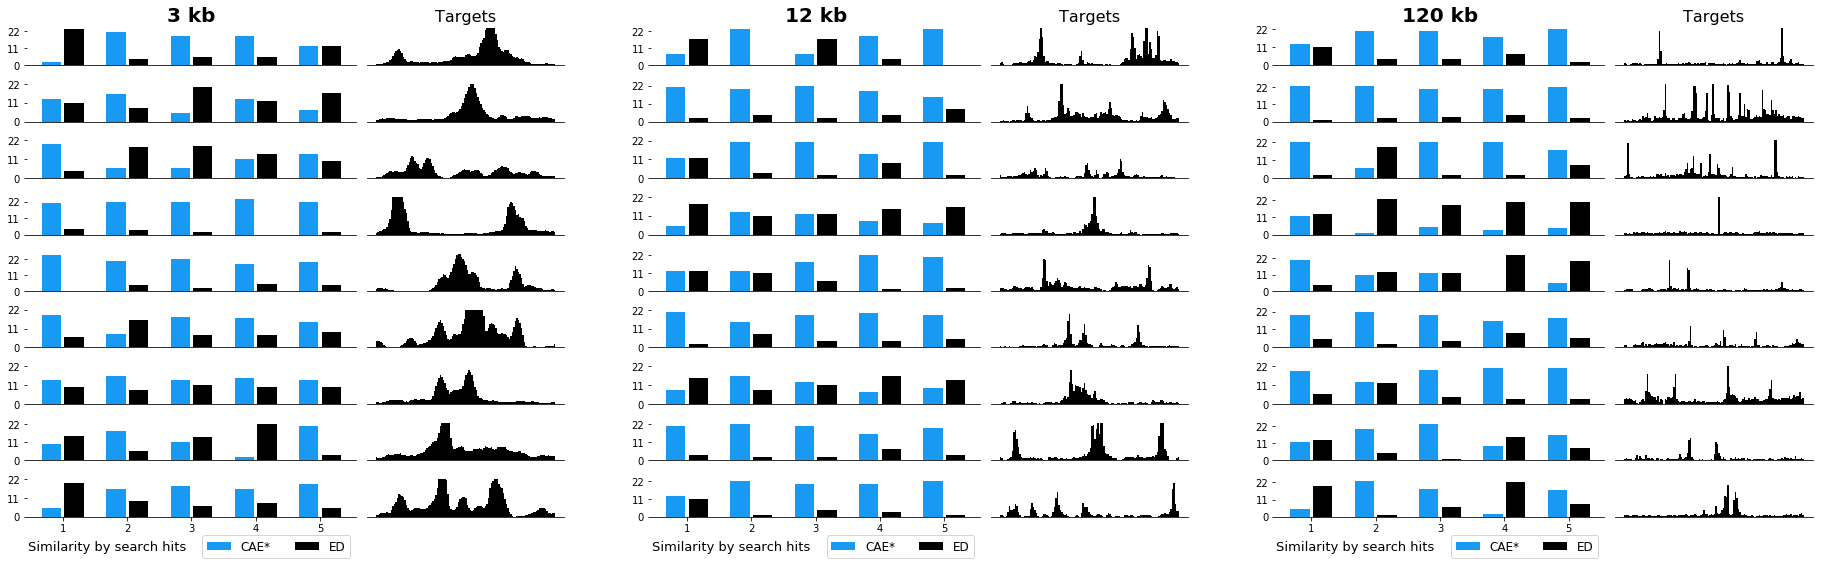

In [107]:
fig, ax = plt.subplots(
    nrows=comparisons,
    ncols=pattern_sizes * 3 - 1,
    figsize=(8 * (pattern_sizes + 1), comparisons),
    gridspec_kw=dict(width_ratios=([1,0.6,0.2] * (pattern_sizes - 1) + [1,0.6]), wspace=0.05, hspace=0.5)
)

with h5py.File('search-targets.h5', 'r') as f:
    for c in range(comparisons):
        for s in range(pattern_sizes):
            res_max = np.max(results[0][0])
            
            ax[c, s * 3].bar(np.arange(knn) + 0, results[s][c][0], label='CAE*', width=0.3, color='#199AF2')
            ax[c, s * 3].bar(np.arange(knn) + 0.35, results[s][c][1], label='ED', width=0.3, color='#000000')
            ax[c, s * 3].set_yticks(range(0, res_max + 1, max(1, res_max // 2)))

            if c == 0:
                ax[c, s * 3].set_title(pattern_sizes_names[s], fontsize=20, fontweight='bold')

            if c < (comparisons - 1):
                ax[c, s * 3].set_xticks([], [])
                ax[c, s * 3].tick_params(axis='x', length=0)
            else:
                ax[c, s * 3].set_xticks(np.arange(knn) + 0.175)
                ax[c, s * 3].set_xticklabels(np.arange(knn) + 1)
                ax[c, s * 3].legend(loc='lower right', bbox_to_anchor=(1, -1.25), ncol=2, fontsize=12)
                ax[c, s * 3].annotate(
                    'Similarity by search hits', xy=(0,0), xytext=(1, -24), ha='left', va='top',
                    xycoords='axes fraction', textcoords='offset points', fontsize=13
                )

            ax[c, s * 3].spines['top'].set_visible(False)
            ax[c, s * 3].spines['left'].set_visible(False)
            ax[c, s * 3].spines['right'].set_visible(False)

            target_pattern = f['targets_{}'.format(pattern_sizes_shortnames[s])][c]
            ax[c, s * 3 + 1].bar(np.arange(target_pattern.size), target_pattern, width=1.0, color='#000000')
            ax[c, s * 3 + 1].set_ylim(0, 1)
            ax[c, s * 3 + 1].set_xticks([], [])
            ax[c, s * 3 + 1].set_yticks([], [])
            ax[c, s * 3 + 1].spines['top'].set_visible(False)
            ax[c, s * 3 + 1].spines['left'].set_visible(False)
            ax[c, s * 3 + 1].spines['right'].set_visible(False)
            if c == 0:
                ax[c, s * 3 + 1].set_title('Targets', fontsize=16)
            
            if s < pattern_sizes - 1:
                ax[c, s * 3 + 2].set_xticks([], [])
                ax[c, s * 3 + 2].set_yticks([], [])
                ax[c, s * 3 + 2].spines['top'].set_visible(False)
                ax[c, s * 3 + 2].spines['right'].set_visible(False)
                ax[c, s * 3 + 2].spines['bottom'].set_visible(False)
                ax[c, s * 3 + 2].spines['left'].set_visible(False)
                
fig.savefig(
    'user-study-2-results-by-knn.png',
    bbox_inches="tight",
    pad_inches=0
)

## Results for all 5 nearest neighbors combined

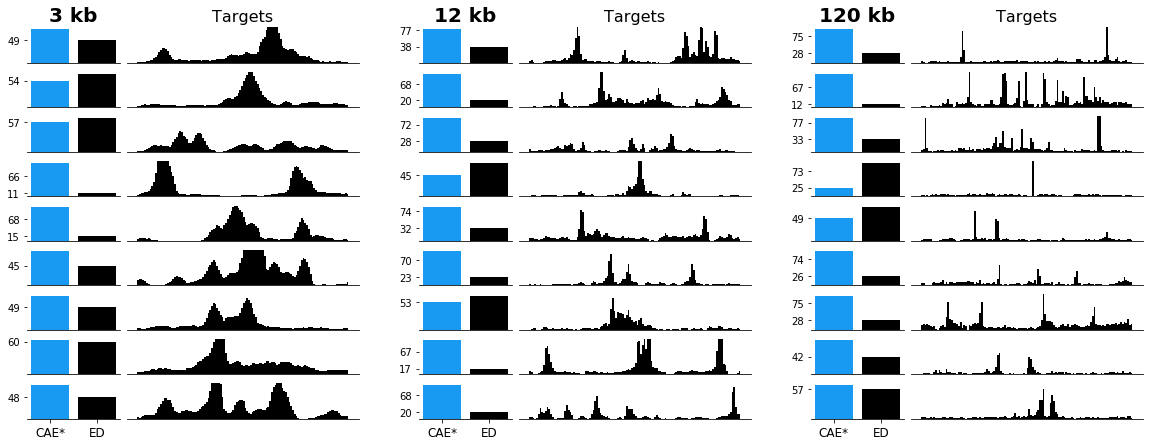

In [106]:
import h5py
import math

fig, ax = plt.subplots(
    nrows=comparisons,
    ncols=pattern_sizes * 3 - 1,
    figsize=(5 * (pattern_sizes + 1), comparisons * 0.8),
    gridspec_kw=dict(width_ratios=([0.4,1,0.2] * (pattern_sizes - 1) + [0.4,1]), wspace=0.05, hspace=0.25)
)

with h5py.File('search-targets.h5', 'r') as f:
    for c in range(comparisons):
        for s in range(pattern_sizes):
            res = np.sum(results[s][c], axis=1)
            for t in range(techniques):
                results[s][c][t]
            ax[c, s * 3].bar(technique_names, res, width=0.8, color=['#199AF2', '#000000'])
            ax[c, s * 3].set_yticks(range(min(res), max(res) + 1, max(1, math.floor(max(res) / 2))))
            if c == 0:
                ax[c, s * 3].set_title(pattern_sizes_names[s], fontsize=20, fontweight='bold')
            if c < (comparisons - 1):
                ax[c, s * 3].tick_params(axis='x', length=0)
                ax[c, s * 3].set_xticks([], [])
            else:
                ax[c, s * 3].set_xticklabels(technique_names, fontsize=12)
            ax[c, s * 3].spines['top'].set_visible(False)
            ax[c, s * 3].spines['left'].set_visible(False)
            ax[c, s * 3].spines['right'].set_visible(False)

            target_pattern = f['targets_{}'.format(pattern_sizes_shortnames[s])][c]
            ax[c, s * 3 + 1].bar(np.arange(target_pattern.size), target_pattern, width=1.0, color='k')
            ax[c, s * 3 + 1].set_ylim(0, 1)
            ax[c, s * 3 + 1].set_xticks([], [])
            ax[c, s * 3 + 1].set_yticks([], [])
            ax[c, s * 3 + 1].spines['top'].set_visible(False)
            ax[c, s * 3 + 1].spines['left'].set_visible(False)
            ax[c, s * 3 + 1].spines['right'].set_visible(False)
            if c == 0:
                ax[c, s * 3 + 1].set_title('Targets', fontsize=16)
            
            if s < pattern_sizes - 1:
                ax[c, s * 3 + 2].set_xticks([], [])
                ax[c, s * 3 + 2].set_yticks([], [])
                ax[c, s * 3 + 2].spines['top'].set_visible(False)
                ax[c, s * 3 + 2].spines['right'].set_visible(False)
                ax[c, s * 3 + 2].spines['bottom'].set_visible(False)
                ax[c, s * 3 + 2].spines['left'].set_visible(False)

fig.savefig(
    'user-study-2-results.png',
    bbox_inches="tight",
    pad_inches=0
)

## Fisher exact test

In [10]:
for s in range(pattern_sizes):
    print('====================')
    print('Size: {}'.format(pattern_sizes_names[s]))
    print('====================')
    print()
    
    results_merged = np.sum(results[s], axis=2)
    
    data = np.concatenate(
        (
            np.sum(results_merged, axis=0).reshape((1, -1)),
            np.array([[
                np.floor(np.sum(results_merged) / 2).astype(np.int),
                np.ceil(np.sum(results_merged) / 2).astype(np.int)
            ]])
        ),
        axis=0
    )
    
    oddsratio, pvalue = stats.fisher_exact(data)
    
    print('P-value   : {}'.format(pvalue))
    print('oddsratio : {}'.format(oddsratio))

Size: 3 kb

P-value   : 2.7521081572554445e-09
oddsratio : 1.6780487804878048
Size: 12 kb

P-value   : 2.7566455204164137e-21
oddsratio : 2.3579775253687245
Size: 120 kb

P-value   : 5.292974615051235e-11
oddsratio : 1.7727272727272727
